In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
#from src.data.make_dataset import make_cat_dict,calc_reactor_metrics
from src.models.constants import Constants
from src.models.util import generate_grid,split,EI,generate_prediction_array,GP_regressor
from src.models.gaussian_process import featurize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import RBF
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_squared_error,pairwise_distances
from sklearn.decomposition import PCA
from sklearn.inspection import PartialDependenceDisplay,partial_dependence
import scipy.stats as ss

In [7]:
plt.style.use('seaborn-v0_8-talk')
cmap = plt.get_cmap("tab10")
raw_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/raw"
processed_dir = "C:/Users/Hermans_Desktop1/OneDrive - UW-Madison/Documents/Research/2022-P4 (Pt DH ML)/iterative_catalyst_design/data/processed"
n_map = {1:"Base",2:"Incl. Rnd 1",3:"Incl. Rnd 2",4:"Incl. Rnd 3",5:"Incl. Rnd 4"}

In [8]:
def avg(df):
    print("Performing averaging")
    print(f'Currently {len(df)} catalyst samples in matrix.')
    metals_to_avg_on = Constants().ALL_TESTED_METALS
    df['idx'] = df.index
    columns_to_retain = Constants().METRICS
    columns_to_retain.append("idx")
    df_avg = df.groupby(Constants().ALL_TESTED_METALS)[columns_to_retain].mean().reset_index()
    df_avg=df_avg.sort_values("idx")
    df_avg.head()
    sd_pct_lifetime = .176
    sd_pct_Y_pc = .033/2
    sd_pct_sqrtY0Y_pc = .033/2 #placeholder
    df_avg["lifetime_yield_sd"] = df_avg["lifetime_yield"]*sd_pct_lifetime #producing an estimated SD for a parameter
    df_avg["Y_pc_sd"] = df_avg["Y_pc"]*sd_pct_Y_pc #producing an estimated SD for a parameter
    df_avg["sqrtY0Y_pc_sd"] = df_avg["sqrtY0Y_pc"]*sd_pct_sqrtY0Y_pc
    df_avg = df_avg.drop(columns=["idx"])
    return df_avg

The purpose of this notebook is to determine the importance of various features towards our models.

# 1) PCA

In [9]:
#load in reactor data
fname = f'3-averaged_Round{5}-Standardized.csv' #Data through Round 4
f = processed_dir+"/"+fname
df = pd.read_csv(f,index_col=0)
pca = PCA()
X = df[Constants().METALS].to_numpy()
pca.fit(X)
pca.explained_variance_ratio_

array([0.39305005, 0.20901225, 0.18658506, 0.13677752, 0.07457513])

As expected, PCA is not particularly useful since each column is just a metal.

# 2) Correlation Matrix

In [10]:
df[Constants().METALS].corr()

,Sn,Ga,Fe,Cu,Ca
Sn,1.000000,-0.135918,-0.073001,-0.260749,-0.087149
Ga,-0.135918,1.000000,-0.064030,-0.218157,-0.199690
Fe,-0.073001,-0.064030,1.000000,-0.217057,-0.154924
Cu,-0.260749,-0.218157,-0.217057,1.000000,0.039062
Ca,-0.087149,-0.199690,-0.154924,0.039062,1.000000


Correlation matrix kind of gives you a sense for what the model has chosen so far. For example the model hasn't tested a lot of samples with Cu and a large amount of another metal (other than Ca).

# 3) Partial Dependence

C:\Users\Hermans_Desktop1\AppData\Local\Temp\ipykernel_19892\4205138724.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['diversity'] = X_temp.astype(bool).sum(axis=1) #counts non-zero in a given row https://stackoverflow.com/questions/26053849/counting-non-zero-values-in-each-column-of-a-dataframe-in-python
C:\Users\Hermans_Desktop1\AppData\Local\Temp\ipykernel_19892\4205138724.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['loading'] = X_temp.sum(axis=1)


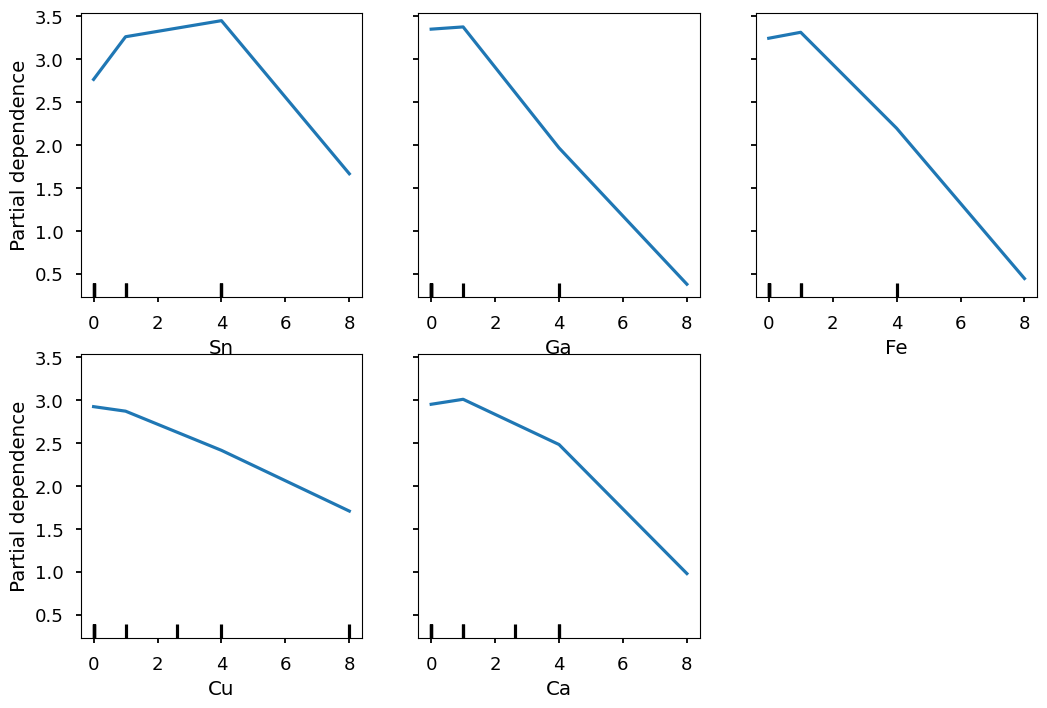

In [33]:
X_temp = df[Constants().METALS] #neglect sum, etc.
X = df[Constants().METALS]
X['diversity'] = X_temp.astype(bool).sum(axis=1) #counts non-zero in a given row https://stackoverflow.com/questions/26053849/counting-non-zero-values-in-each-column-of-a-dataframe-in-python
X['loading'] = X_temp.sum(axis=1)
y = df["sqrtY0Y_pc"].to_numpy()
kernel = 1*RBF(length_scale=1.0,length_scale_bounds=(1e-2,1e2))
gp = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=5)
gp.fit(X,y)
feature_names = df[Constants().METALS].columns
features = ['Sn','Ga','Fe','Cu','Ca']
PartialDependenceDisplay.from_estimator(gp, X, features,feature_names=feature_names)
plt.tight_layout()
plt.show()
#plt.savefig('./figures/partial-dependence-1d.png',dpi=600)

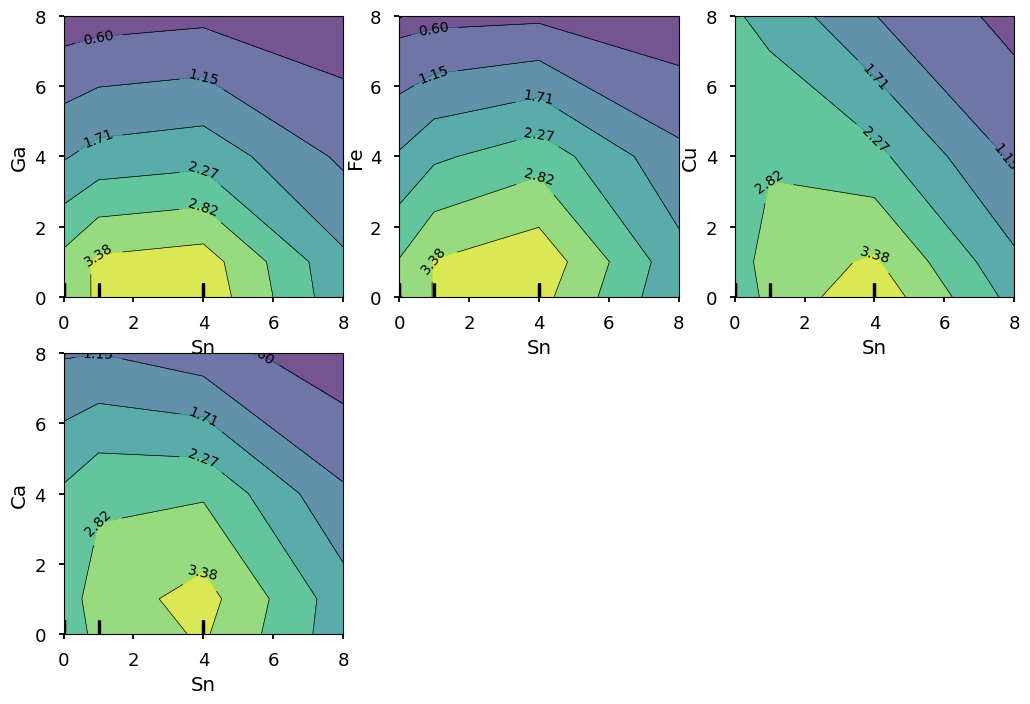

In [34]:
features = [('Sn','Ga'),('Sn','Fe'),('Sn','Cu'),('Sn','Ca')]
PartialDependenceDisplay.from_estimator(gp, X, features)
plt.tight_layout()
plt.show()
#plt.savefig('./figures/partial-dependence-2d.png',dpi=600)

# 4) Trying to make everything Gaussian distrib. beforehand and apply 10-fold CV {After splitting into test and train. Need to create a transformation. Use pipeline}. Does this work better?